In [1]:
#importing libraries and my own statistical function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import geopandas as gp
import sys

sys.path.insert(0, "../Notebooks/Functions")
import StatsFunctions as MF

In [2]:
# reading the data in
Countries = pd.read_excel(
    "../Data/UNDP data/HDR21-22_Statistical_Annex_HDI_Table.xlsx",
    sheet_name="Table 1",
    header=5,
    usecols="B:C",
    nrows=201,
)

In [3]:
Countries = Countries.dropna().query("Value != '..'")["Country"].reset_index(drop=True)

In [4]:
Rest = pd.read_excel(
    "../Data/UNDP data/HDR21-22_Statistical_Annex_HDI_Table.xlsx",
    sheet_name="Table 1",
    header=4,
    usecols="C,E,G,I,K,M,O",
    nrows=198,
)

In [5]:
Rest = Rest.dropna().drop(index=1, axis=1).reset_index(drop=True)

In [6]:
IQ = pd.read_html("../Data/HTML data/Countries by Average IQ 2023.html")[-1]

In [7]:
combined2 = pd.concat([Countries, Rest], axis=1)

In [8]:
world = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))

C:\Users\dima1\AppData\Local\Temp\ipykernel_6340\2637584309.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))


In [9]:
# changing names of certain countries, as there are some mis-matches, which will result in less data captured
combined2["Country"].replace(
    {
        "Viet Nam": "Vietnam",
        "Korea (Republic of)": "South Korea",
        "Türkiye": "Turkey",
        "Russian Federation": "Russia",
        "Iran (Islamic Republic of)": "Iran",
        "Moldova (Republic of)": "Moldova",
        "Palestine, State of": "Palestine",
        "Venezuela (Bolivarian Republic of)": "Venezuela",
        "Bolivia (Plurinational State of)": "Bolivia",
        "Syrian Arab Republic": "Syria",
        "United States": "United States of America",
        "Tanzania (United Republic of)": "Tanzania",
        "Congo (Democratic Republic of the)": "Dem. Rep. Congo",
    },
    inplace=True,
)

IQ["Region"].replace(
    {
        "Czech Republic": "Czechia",
        "Republic of the Congo": "Congo",
        "United States": "United States of America",
        "DR Congo": "Dem. Rep. Congo",
    },
    inplace=True,
)

world["name"].replace(
    {
        "Dominican Rep.": "Dominican Republic",
        "Central African Rep.": "Central African Republic",
        "Bosnia and Herz.": "Bosnia and Herzegovina",
        "S. Sudan": "South Sudan",
    },
    inplace=True,
)

In [10]:
DF = pd.merge(
    left=IQ, right=combined2, how="outer", left_on="Region", right_on="Country"
)

In [11]:
# renaming columns for easier access

DF.rename(
    {
        "Human Development Index (HDI) ": "HDI",
        "Life expectancy at birth": "LifeExpectancy",
        "Expected years of schooling": "ExpectedYearsOfScholing",
        "Mean years of schooling": "MeanYearsOfSchooling",
        "Gross national income (GNI) per capita": "GNI",
        "Average IQ": "IQ",
    },
    axis=1,
    inplace=True,
)

In [12]:
# re-casting a type for number manipulaiton
DF = DF.astype(
    {
        "HDI": "float",
        "LifeExpectancy": "float",
        "ExpectedYearsOfScholing": "float",
        "MeanYearsOfSchooling": "float",
        "GNI": "float",
        "GNI per capita rank minus HDI rank": "float",
        "HDI rank": "float",
        "IQ": "float",
    }
)

In [13]:
d1 = pd.merge(
    left=world[["continent", "name", "pop_est", "iso_a3", "geometry"]],
    right=DF,
    left_on="name",
    right_on="Region",
)

In [14]:
d2 = pd.merge(
    left=world[["continent", "name", "pop_est", "iso_a3", "geometry"]],
    right=DF,
    left_on="name",
    right_on="Country",
)

In [15]:
DF = pd.merge(d1, d2, how="outer").dropna()

In [16]:
DF = DF.rename({"continent": "Continent", "pop_est": "Population"}, axis=1)[
    [
        "Continent",
        "Country",
        "iso_a3",
        "geometry",
        "HDI",
        "LifeExpectancy",
        "ExpectedYearsOfScholing",
        "MeanYearsOfSchooling",
        "GNI",
        "IQ",
    ]
]

In [17]:
#creating same colour set for continents
colours = dict(zip(DF["Continent"].unique(), sns.color_palette("bright", 6).as_hex()))
kwargs = {"hue": "Continent", "palette": colours, "edgecolor": "black", "alpha": 0.6}

In [18]:
#creating world map for each country and their respective average IQ
fig = px.choropleth(
    DF,
    locations="iso_a3",
    color="IQ",
    color_continuous_scale="thermal",
    hover_data="Country",
)
fig.update_layout(
    margin={"r": 30, "t": 50, "l": 500, "b": 0},
    title_text="Average IQ of countries",
    title_x=0.5,
    autosize=True,
)


fig.show()

In [19]:
# selecting data for a part of report
DF.loc[
    (DF["Country"] == "Togo")
    | (DF["Country"] == "Ghana")
    | (DF["Country"] == "United States of America"),
    ["Country", "Continent", "IQ"],
]

,Country,Continent,IQ
3,United States of America,North America,97.43
55,Togo,Africa,59.83
56,Ghana,Africa,58.16


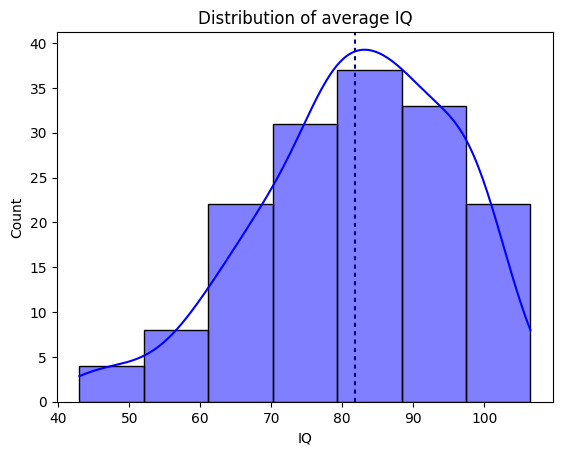

In [20]:
# distribution of IQ with world's average IQ
sns.histplot(DF, x="IQ", bins=7, kde=True, color="blue")

plt.axvline(MF.mean(DF["IQ"]), color="darkblue", label="mean", dashes=(2, 2))

plt.title("Distribution of average IQ")
plt.show()

In [21]:
#displaying 5 smartest countries with 
pd.DataFrame(DF.sort_values(by="IQ", ascending=False).head(5))[
    ["Continent", "Country", "IQ"]
]

,Continent,Country,IQ
147,Asia,Japan,106.48
131,Asia,China,104.10
89,Asia,South Korea,102.35
104,Europe,Belarus,101.60
143,Europe,Finland,101.20


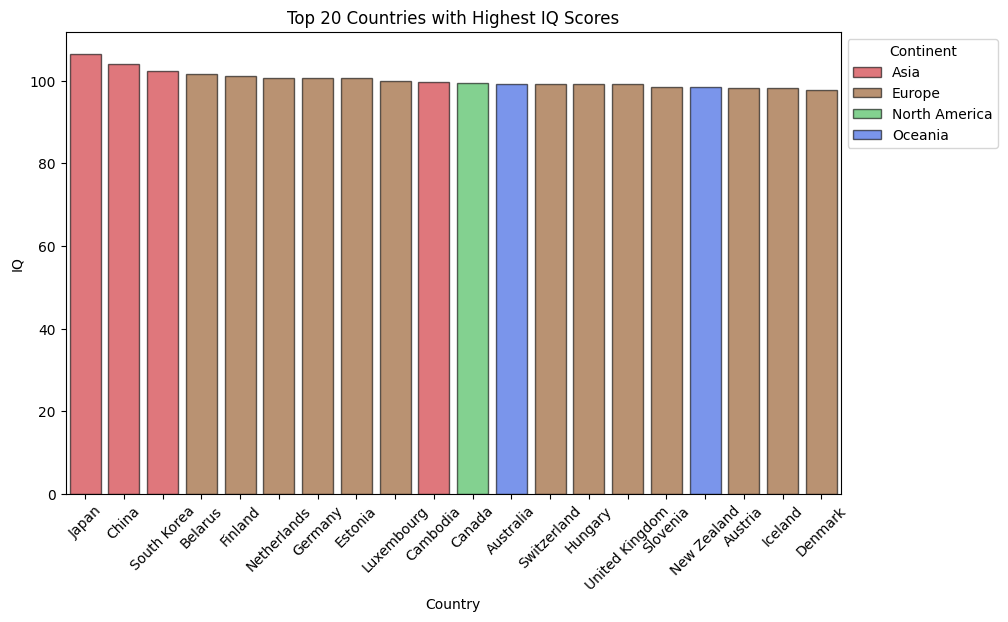

In [22]:
# displaying visually top 20 countries
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=DF.sort_values(by="IQ", ascending=False).head(20),
    x="Country",
    y="IQ",
    **kwargs
)
plt.xticks(rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Top 20 Countries with Highest IQ Scores")
plt.show()

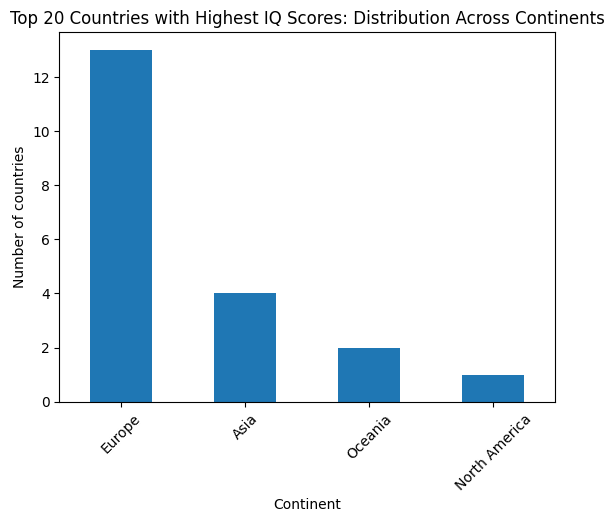

In [23]:
# same barplot as above, but groupped by continents
DF.sort_values(by="IQ", ascending=False)["Continent"].head(20).value_counts().plot.bar()
plt.xticks(rotation=45)
plt.title("Top 20 Countries with Highest IQ Scores: Distribution Across Continents")
plt.ylabel("Number of countries")
plt.show()

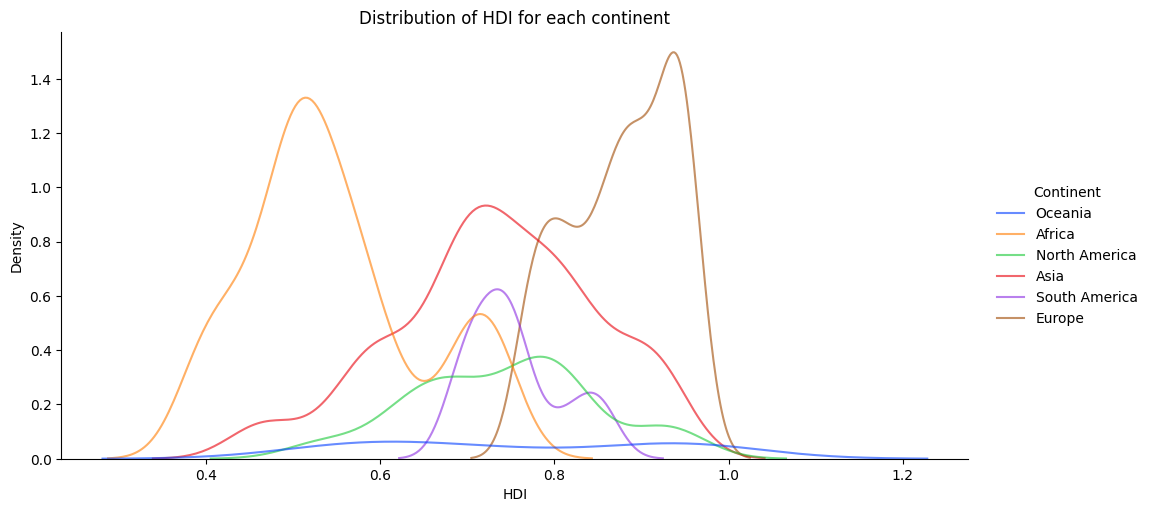

In [24]:

sns.displot(
    data=DF,
    x="HDI",
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor"]}, # kde plot doesn't have this parameter, so had to filter it.
    aspect=2,
    kind="kde",
    bw_adjust=0.7
)


plt.title("Distribution of HDI for each continent")

plt.show()
#didn't end up using this graph

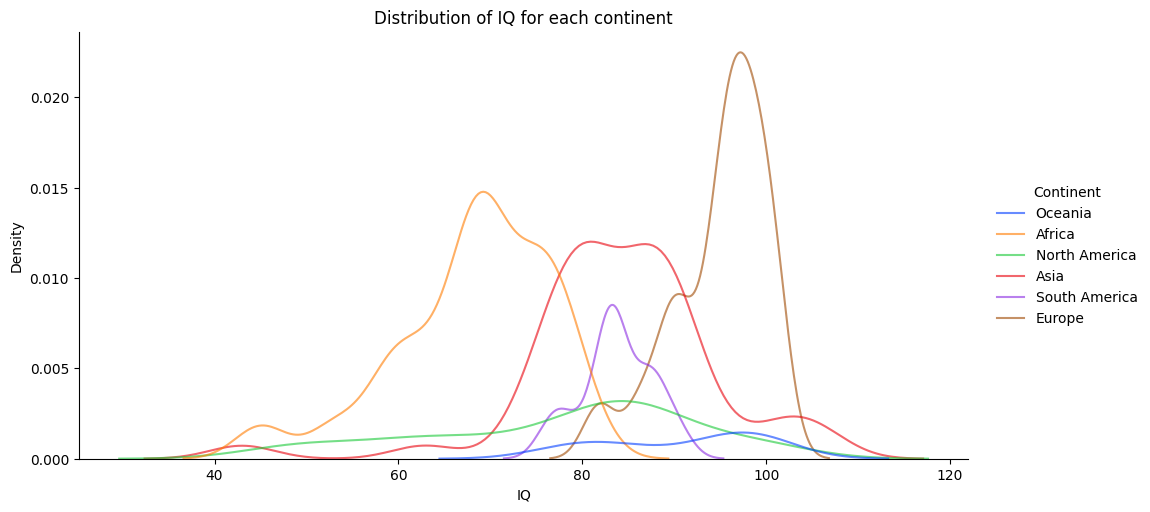

In [25]:
sns.displot(
    data=DF,
    x="IQ",
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor"]},
    aspect=2,
    kind="kde",
    bw_adjust=0.7
)


plt.title("Distribution of IQ for each continent")
plt.show()
#didn't end up using it

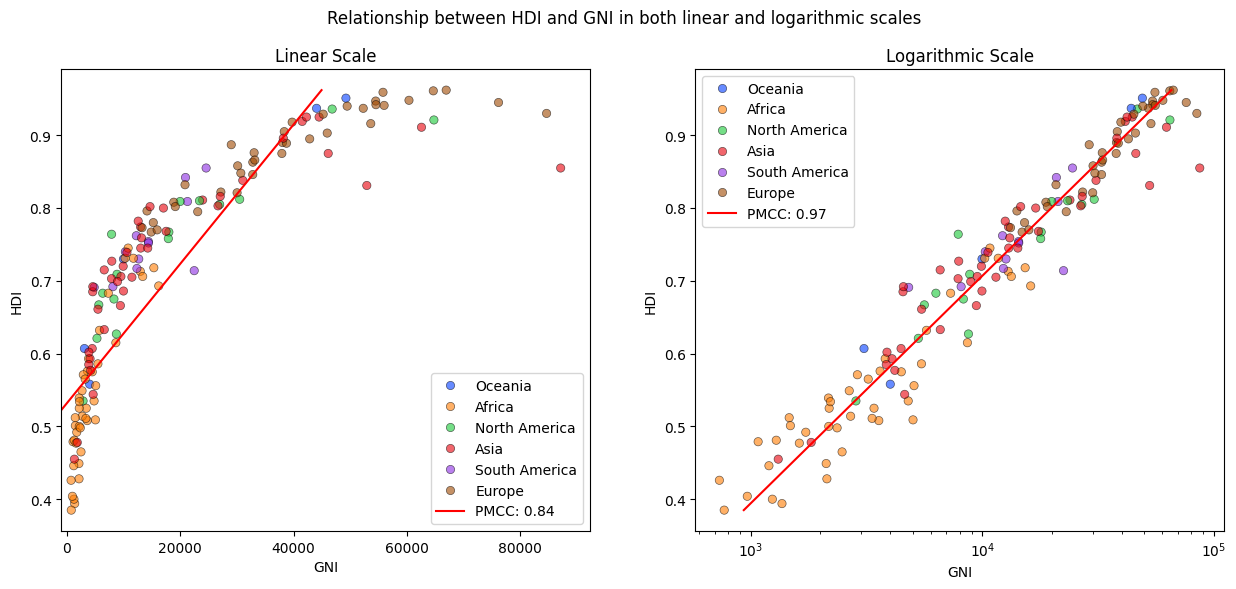

In [26]:
# I use the same method throughout the notebook, so will explain it here

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# crearing 2 subplots to display difference between linear and log scale graphs


m, q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["GNI"].to_list())
# finding multiplier, intercept and correlation coefficient using my function


m1, q1, cor1 = MF.linear_regression(DF["HDI"].to_list(), np.log10(DF["GNI"].to_list()))

# plotting linear values and setting linear part of the plot

sns.scatterplot(
    data=DF,
    x="GNI",
    y="HDI",
    **kwargs,
    ax=axes[0],
)

sns.lineplot(
    y=DF["HDI"],
    x=m * DF["HDI"] + q,
    label=f"PMCC: {round(cor, 2)}",
    color="red",
    ax=axes[0],
)


axes[0].set_title("Linear Scale")
axes[0].set_xlim((-1000, None))


axes[1].set_xscale("log")  # setting the plot to log scale on x-axis
X = np.column_stack((np.ones_like(DF["HDI"]), DF["HDI"])) 
# Creates a matrix X by stacking two columns, where the first column consists of ones (for the intercept term) and the second column contains the values from the 'HDI' column of the DataFrame.

y_log = np.log(DF["GNI"]) #applies natural log to the whole GNI column


theta = np.linalg.inv(X.T @ X) @ X.T @ y_log # uses formula for normal equation (https://www.datacamp.com/tutorial/tutorial-normal-equation-for-linear-regression or https://www.geeksforgeeks.org/ml-normal-equation-in-linear-regression/)
# theta is a 2x1 matrix which are coefficients


#Predicts the logarithmically transformed values of 'GNI'  
y_pred_log = X @ theta


# Plot the linear regression line
sns.scatterplot(data=DF, x="GNI", y="HDI", **kwargs, ax=axes[1])


sns.lineplot(
    y=DF["HDI"],
    x=np.exp(y_pred_log),
    label=f"PMCC: {round(cor1, 2)}",
    color="red",
    ax=axes[1],
)


axes[1].set_title("Logarithmic Scale")

fig.suptitle("Relationship between HDI and GNI in both linear and logarithmic scales")



plt.show()

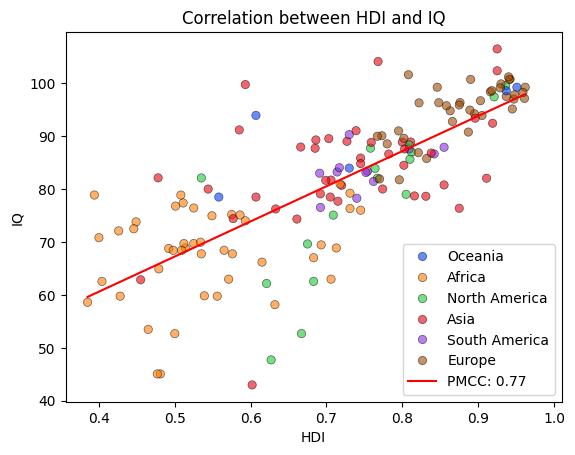

In [27]:
fig, ax = plt.subplots()
m, q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["IQ"].to_list())

sns.scatterplot(data=DF, x="HDI", y="IQ", **kwargs)
sns.lineplot(
    x=DF["HDI"], y=m * DF["HDI"] + q, label=f"PMCC: {round(cor, 2)}", color="red", ax=ax
)
plt.title("Correlation between HDI and IQ")
plt.xlim((None, 1.01))
plt.show()

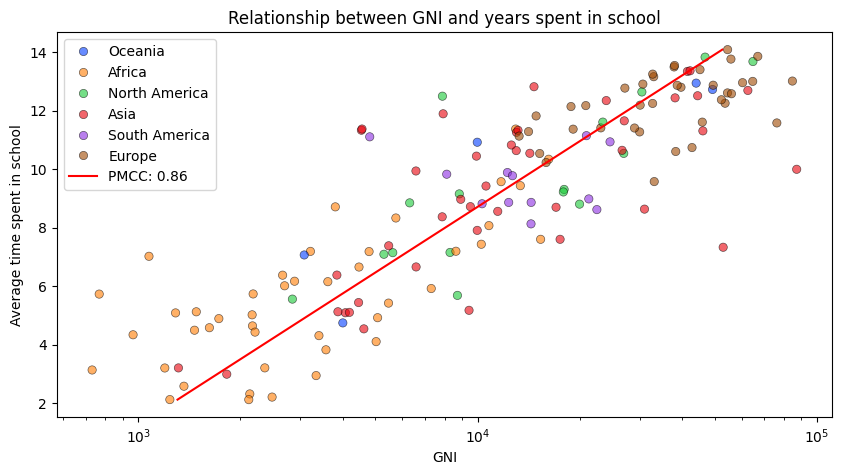

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=DF, x="GNI", y="MeanYearsOfSchooling", **kwargs, ax=ax)
plt.title("Relationship between GNI and years spent in school")
plt.xscale("log")

m1, q1, cor1 = MF.linear_regression(
    DF["MeanYearsOfSchooling"].to_list(), np.log10(DF["GNI"].to_list())
)


X = np.column_stack(
    (np.ones_like(DF["MeanYearsOfSchooling"]), DF["MeanYearsOfSchooling"])
)
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log

y_pred_log = X @ theta

sns.lineplot(
    x=np.exp(y_pred_log),
    y=DF["MeanYearsOfSchooling"],
    color="red",
    label=f"PMCC: {round(cor1, 2)}",
    ax=ax,
)


ax.set_ylabel("Average time spent in school")

plt.show()

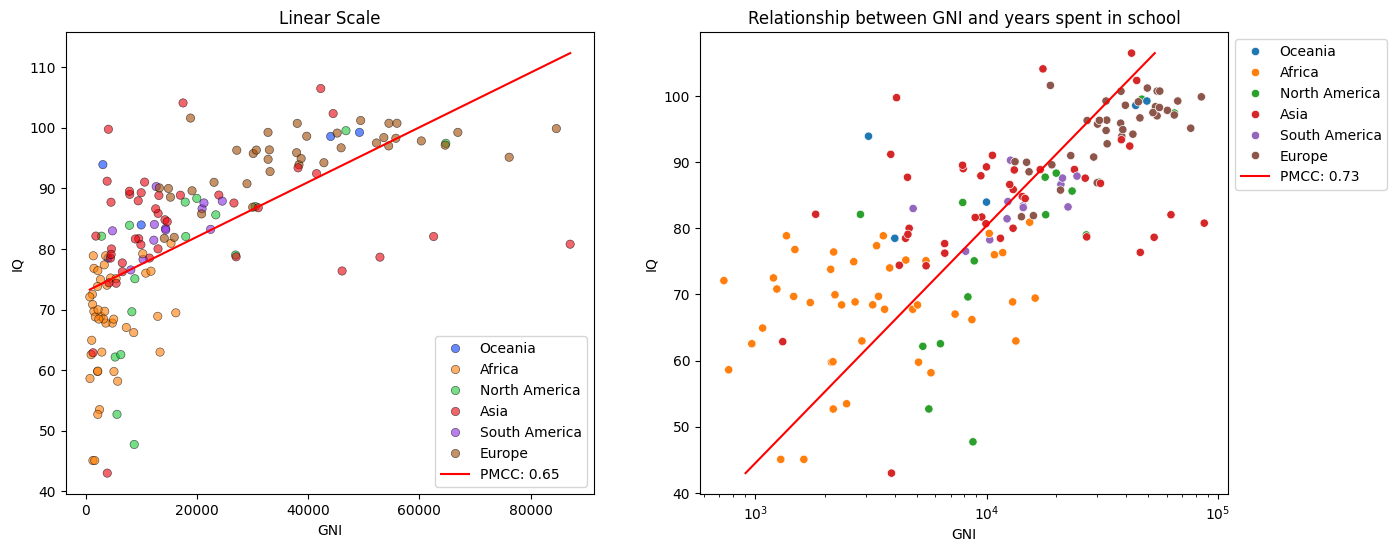

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


m, q, cor = MF.linear_regression(DF["GNI"].to_list(), DF["IQ"].to_list())
sns.scatterplot(data=DF, y="IQ", x="GNI", **kwargs, ax=axes[0])
sns.lineplot(
    x=DF["GNI"],
    y=m * DF["GNI"] + q,
    label=f"PMCC: {round(cor, 2)}",
    color="red",
    ax=axes[0],
)
axes[0].set_title("Linear Scale")


sns.scatterplot(data=DF, x="GNI", y="IQ", hue="Continent", ax=axes[1])
plt.title("Relationship between GNI and years spent in school")
axes[1].set_xscale("log")  # Set x-axis to log scale

m1, q1, cor1 = MF.linear_regression(DF["IQ"].to_list(), np.log10(DF["GNI"].to_list()))


X = np.column_stack((np.ones_like(DF["IQ"]), DF["IQ"]))
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log
# Predict y values using the linear regression model
y_pred_log = X @ theta

sns.lineplot(
    x=np.exp(y_pred_log),
    y=DF["IQ"],
    color="red",
    label=f"PMCC: {round(cor1, 2)}",
    ax=axes[1],
)

sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))


plt.show()

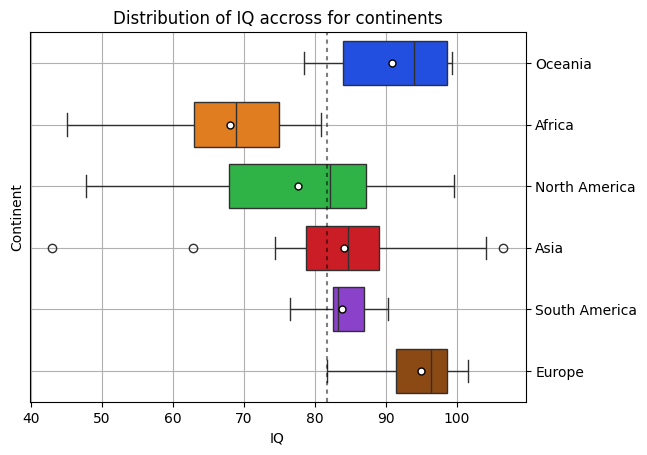

In [30]:
ax = sns.boxplot(
    data=DF,
    x="IQ",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "5",
    }
)

plt.axvline(
    x=MF.mean(DF["IQ"]),
    color="black",
    alpha=0.5,
    dashes=(2, 2),
)
ax.grid()
# ax.tick_params(axis="y", rotation=45, )
ax.yaxis.tick_right()


plt.title("Distribution of IQ accross for continents")
plt.show()

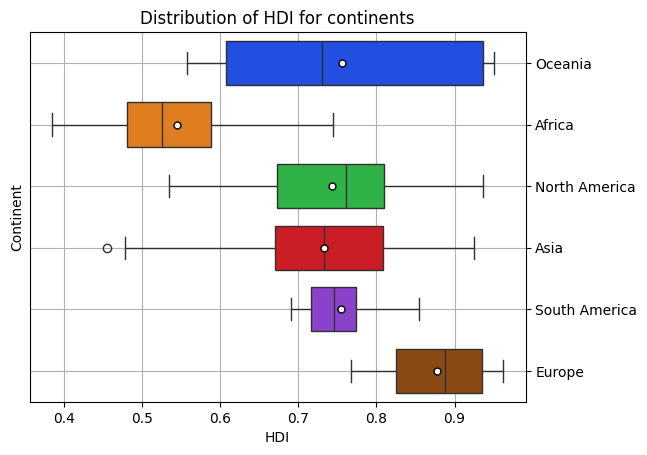

In [31]:
ax = sns.boxplot(
    data=DF,
    x="HDI",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "5",
    }
)

ax.grid()
ax.yaxis.tick_right()


plt.title("Distribution of HDI for continents")
plt.show()

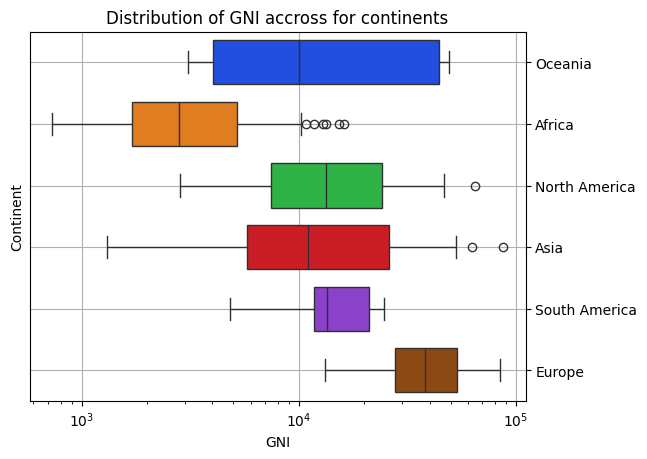

In [32]:
ax = sns.boxplot(
    data=DF,
    x="GNI",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2
)

ax.grid()
ax.yaxis.tick_right()
ax.set_xscale("log")


plt.title("Distribution of GNI accross for continents")
plt.show()

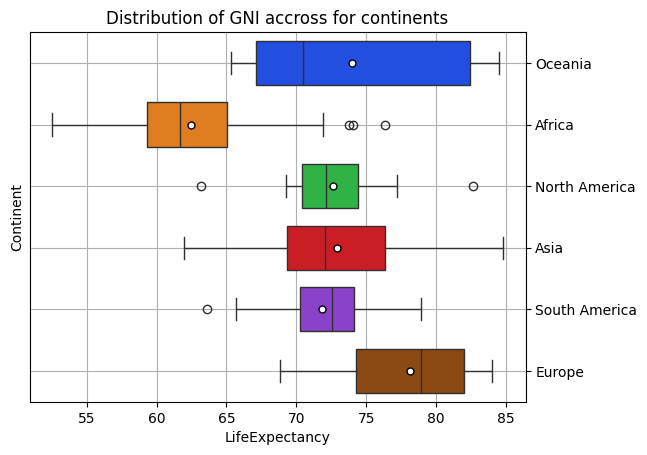

In [33]:
ax = sns.boxplot(
    data=DF,
    x="LifeExpectancy",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "5",
    }
)

ax.grid()
ax.yaxis.tick_right()


plt.title("Distribution of GNI accross for continents")  #
plt.show()

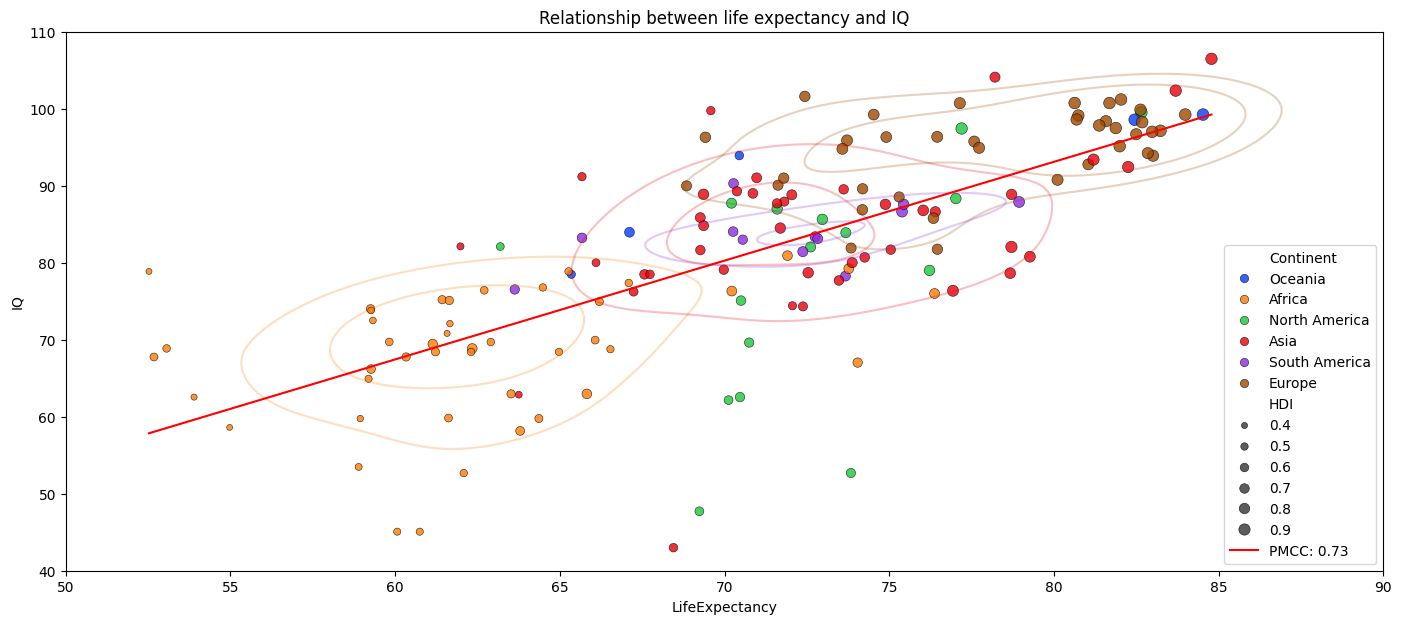

In [34]:
fig, ax = plt.subplots(figsize=(17, 7))

m, q, cor = MF.linear_regression(DF["LifeExpectancy"].to_list(), DF["IQ"].to_list())
sns.scatterplot(
    data=DF,
    x="LifeExpectancy",
    y="IQ",
    **{i: kwargs[i] for i in kwargs if i not in ["alpha"]},
    alpha=0.8,
    size="HDI",
    ax=ax,
)
sns.kdeplot(
    data=DF,
    x="LifeExpectancy",
    y="IQ",
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    levels=3,
    thresh=0.4,
    alpha=0.25,
)
sns.lineplot(
    x=DF["LifeExpectancy"],
    y=m * DF["LifeExpectancy"] + q,
    label=f"PMCC: {round(cor, 2)}",
    color="red",
    ax=ax,
)

sns.move_legend(ax, "lower right")
ax.set_xlim((50, 90))
ax.set_ylim((40, 110))
plt.title("Relationship between life expectancy and IQ")

plt.show()

In [35]:
fig = px.choropleth(
    DF,
    locations="iso_a3",
    color="LifeExpectancy",
    color_continuous_scale="thermal",
    hover_data="Country",
)
fig.update_layout(
    margin={"r": 30, "t": 50, "l": 500, "b": 0},
    title_text="Average IQ of countries",
    title_x=0.5,
    autosize=True,
)


fig.show()